# PLASPIX: Find best hyper parameters

This notebook finds the best hyper parameters for Point Label Aware Superpixels approach (a.k.a. PLASPIX in this project)

## Setups

### Logger Setup

In [1]:
import logging

In [2]:
# define a formatter to display the messages to console (standard output)
console_formatter = logging.Formatter('%(message)s')
console_handler = logging.StreamHandler()
console_handler.setFormatter(console_formatter)

In [3]:
# define a logger for this notebook and attach the console handler
logger = logging.getLogger('PLASPIX-Grid-Search')
logger.handlers.clear()
logger.propagate = False
logger.addHandler(console_handler)

In [4]:
# set an appropriate level of logging for this notebook
logger.setLevel(logging.INFO)

### Mount GCS Bucket

References:
1. [Mount a Cloud Storage bucket using Cloud Storage FUSE](https://cloud.google.com/storage/docs/gcsfuse-quickstart-mount-bucket)
2. [Snippets: Saving Data to Google Cloud Storage](https://colab.research.google.com/notebooks/snippets/gcs.ipynb)
3. [Connect Colab to GCS Bucket Using gcsfuse](https://pub.towardsai.net/connect-colab-to-gcs-bucket-using-gcsfuse-29f4f844d074)

**Authentication**

This step authenticates the user in order to access Google Storage Bucket using an authenticated account.

In [5]:
from google.colab import auth
auth.authenticate_user()

**Install Cloud Storage FUSE**

1. Add the Cloud Storage FUSE distribution URL as a package source:

In [6]:
# check if gcsfuse.list file exists at the path it normally resides
!ls /etc/apt/sources.list.d

archive_uri-https_cloud_r-project_org_bin_linux_ubuntu-jammy.list
c2d4u_team-ubuntu-c2d4u4_0_-jammy.list
cuda-ubuntu2204-x86_64.list
deadsnakes-ubuntu-ppa-jammy.list
graphics-drivers-ubuntu-ppa-jammy.list
ubuntugis-ubuntu-ppa-jammy.list


In [7]:
# open gcsfuse.list file and show its contents
!cat /etc/apt/sources.list.d/gcsfuse.list

cat: /etc/apt/sources.list.d/gcsfuse.list: No such file or directory


In [8]:
# add Cloud Storage FUSE distribution URL as a package source
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list

deb https://packages.cloud.google.com/apt gcsfuse-jammy main


In [9]:
# open gcsfuse.list file and show its contents
!cat /etc/apt/sources.list.d/gcsfuse.list

deb https://packages.cloud.google.com/apt gcsfuse-jammy main


2. Import the Google Cloud APT repository public key and add it to your list of keys:

In [10]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  19494      0 --:--:-- --:--:-- --:--:-- 19551
OK


3. Updates the list of available packages and install gcsfuse:

In [11]:
!apt -qq update && apt -qq install gcsfuse

30 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 5,415 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../gcsfuse_1.4.0_amd64.deb ...
Unpacking gcsfuse (1.4.0) ...
Setting up gcsfuse (1.4.0) ...


In [12]:
# check if gcsfuse is installed
!gcsfuse -v

gcsfuse version 1.4.0 (Go version go1.21.5)


**Mount Bucket on Colab Disk**

Initialize bucket name and the folder on Colab on which the bucket will be mounted

In [13]:
BUCKET_NAME = 'rs_storage_open'
BUCKET_MOUNT_DIR = f"/mnt/gs/{BUCKET_NAME}"

Create a directory to mount the storage bucket to

In [14]:
!mkdir -p {BUCKET_MOUNT_DIR}

In [15]:
!ls -l /mnt/gs

total 4
drwxr-xr-x 2 root root 4096 Jan  4 07:08 rs_storage_open


Mount your storage bucket using the gcsfuse command:

In [16]:
!gcsfuse --implicit-dirs {BUCKET_NAME} {BUCKET_MOUNT_DIR}

{"time":"04/01/2024 07:08:17.879327","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /mnt/gs/rs_storage_open\n"}


In [17]:
!ls -l {BUCKET_MOUNT_DIR}

total 9
drwxr-xr-x 1 root root    0 Jan  4 07:08 benthic_datasets
-rw-r--r-- 1 root root 8514 Nov 14 13:31 README.md


### Mount Google Drive

In [18]:
import os
from google.colab import drive

In [19]:
DRIVE_MOUNT_DIR = '/content/drive'
drive.mount(DRIVE_MOUNT_DIR, force_remount=True)

Mounted at /content/drive


### Directory Setup

Local Root Directory

In [20]:
# local root directory for this notebook
LOCAL_ROOT_DIR = '/content'

Bucket Mount Directory

In [21]:
# Root folder for dataset
logger.info(f"Root directory for dataset: {BUCKET_MOUNT_DIR}")

Root directory for dataset: /mnt/gs/rs_storage_open


Project Root Directory

In [22]:
# Root folder in Google Drive for this project
PROJECT_ROOT_DIR = os.path.join(DRIVE_MOUNT_DIR, 'MyDrive', '20231114-FruitPunch-AI-for-Coral-Reefs-2')
logger.info(f"Root directory for project in Google Drive: {PROJECT_ROOT_DIR}")

Root directory for project in Google Drive: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2


### Custom Libraries & Weights

In [23]:
import sys
import shutil

In [24]:
# add the path where point label aware superpixels and custom packags is located
sys.path.append(os.path.join(PROJECT_ROOT_DIR, 'packages'))

In [25]:
# dowload the pre-trained weights mentioned in GitHub and point to that file
PRE_TRAINED_WEIGHTS = os.path.join(PROJECT_ROOT_DIR, 'models', 'standardization_C=100_step70000.pth')

# copy the pre-trained weights file to the code folder created by git clone
if os.path.exists(PRE_TRAINED_WEIGHTS):
    logger.info(f"Copying weights from {PRE_TRAINED_WEIGHTS}...")
    shutil.copyfile(
        PRE_TRAINED_WEIGHTS,
        os.path.join(LOCAL_ROOT_DIR, 'standardization_C=100_step70000.pth'),
        )
    logger.info(os.listdir(LOCAL_ROOT_DIR))

Copying weights from /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/models/standardization_C=100_step70000.pth...
['.config', 'drive', 'standardization_C=100_step70000.pth', 'sample_data']


### Dependencies

In [26]:
import torch

In [27]:
# workaround to overcome long duration needed for installing torch_scatter
!pip install pyg_lib torch_scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 96.0 MB/s eta 0:00:00


In [28]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.1 MB/s eta 0:00:00


In [29]:
import pandas as pd

from pathlib import Path

In [30]:
from labelmate.loader import LabelPropDataLoader
from labelmate.visualizer import visualize_output
from labelmate.evaluator import LabelPropEvaluator
from labelmate.propagator import PLASPIXLabelProp
from labelmate.hypertuner import PLASPIXLabelPropGridSearch

In [31]:
custom_modules = ['labelmate.loader', 'labelmate.visualizer',
                  'labelmate.evaluator', 'labelmate.propagator',
                  'labelmate.hypertuner',
                  ]
for module_name in custom_modules:
    logging.getLogger(module_name).setLevel(logging.INFO)

## Input Variables

In [32]:
# Path to folder that contains images and dense masks
DATA_ROOT_DIR = os.path.join(BUCKET_MOUNT_DIR, 'benthic_datasets', 'mask_labels', 'reef_support')
logger.info(f"Dataset (images and masks) will be accessed from: {DATA_ROOT_DIR}")

Dataset (images and masks) will be accessed from: /mnt/gs/rs_storage_open/benthic_datasets/mask_labels/reef_support


In [33]:
# Path to permanently store input images, input sparse masks in image format and output from PLASPIX
RESULTS_UPLOAD_PATH = os.path.join(PROJECT_ROOT_DIR, 'findings', 'PLASPIX-POC-V4')
logger.info(f"Results obtained will be saved to: {RESULTS_UPLOAD_PATH}")

Results obtained will be saved to: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4


In [34]:
# Path to the csv that contains image level summary for Seaview labelled by Reef Support
REEF_SUPPORT_SEAVIEW_MANIFEST_PATH = os.path.join(PROJECT_ROOT_DIR, 'data', 'MANIFEST_REEF_SUPPORT_V1.csv')
logger.info(f"Dataset manifest will be accessed from: {REEF_SUPPORT_SEAVIEW_MANIFEST_PATH}")

Dataset manifest will be accessed from: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/data/MANIFEST_REEF_SUPPORT_V1.csv


In [35]:
# Combined Point Labels data from Reef Support Dense Masks and Seaview Point Labels with results of label comparison exercise
REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH = os.path.join(PROJECT_ROOT_DIR, 'data', 'DATA-REEF-SUPPORT-POINT-LABELS-v1.csv')
logger.info(f"Point labels data will be loaded from: {REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH}")

Point labels data will be loaded from: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/data/DATA-REEF-SUPPORT-POINT-LABELS-v1.csv


## Dataset Preparation

### Read Manifest & Point Labels

In [36]:
manifest_df = pd.read_csv(REEF_SUPPORT_SEAVIEW_MANIFEST_PATH, header='infer')
point_labels_df = pd.read_csv(REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH, header='infer')

In [37]:
point_labels_df['class_name'] = point_labels_df.reef_support_class_name
point_labels_df['class_label'] = point_labels_df.reef_support_class_label

### Sample Selection

In [38]:
# quadrat_ids = [17001652802, 24047242502]
quadrat_ids = [20034061802, 17025816302, 17019874202, 20034067102, 17017815902, 25009056001, 20029004202, 20042103002, 24026197901, 17019871102]
# quadrat_ids = [17001652802]

### Dataset Data Frame

In [39]:
samples = []

for quadrat_id in quadrat_ids:
    folder = manifest_df.query(f"quadratid == {quadrat_id}").folder.item()
    sample = dict(
        sample_id=quadrat_id,
        dataset_name='reef_support',
        region=manifest_df.query(f"quadratid == {quadrat_id}").region.item(),
        image_path=os.path.join(DATA_ROOT_DIR, folder, 'images', f"{quadrat_id}.jpg"),
        mask_path=os.path.join(DATA_ROOT_DIR, folder, 'masks_stitched', f"{quadrat_id}_mask.png"),
        point_labels_source='SPARSE',
        point_labels_count=100,
    )
    samples.append(sample)

dataset_df = pd.DataFrame(samples)
dataset_df

,sample_id,dataset_name,region,image_path,mask_path,point_labels_source,point_labels_count
0,20034061802,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
1,17025816302,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
2,17019874202,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
3,20034067102,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
4,17017815902,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
5,25009056001,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
6,20029004202,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
7,20042103002,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
8,24026197901,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100
9,17019871102,reef_support,ATL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100


## Dataloader Setup

In [40]:
label_prop_data = \
    LabelPropDataLoader(
        experiment_name='PLASPIX-POC-V4',
        dataset=dataset_df.copy(),
        point_labels=point_labels_df.copy(),
        num_classes=3,
        working_folder=Path('/content/labelprop')
        )

In [41]:
label_prop_data.sub_folders

{'images': PosixPath('/content/labelprop/images'),
 'labels': PosixPath('/content/labelprop/labels'),
 'masks': PosixPath('/content/labelprop/masks'),
 'predictions': PosixPath('/content/labelprop/predictions')}

In [42]:
label_prop_data.delete_sub_folders()

In [43]:
label_prop_data.delete_folder(label_prop_data.sub_folders['predictions'], 'predictions')

In [44]:
label_prop_data.create_sub_folders()

In [45]:
label_prop_data.prepare_input_data()

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
label_prop_data[0]

{'experiment_name': 'PLASPIX-POC-V4',
 'sample_id': 20034061802,
 'image_path': PosixPath('/content/labelprop/images/20034061802.png'),
 'mask_path': PosixPath('/content/labelprop/masks/20034061802.png'),
 'prediction_path': PosixPath('/content/labelprop/predictions/20034061802.png'),
 'point_labels':          quadratid    y    x         label_name  label  func_group  method  \
 27000  20034061802  147   66       Algae matrix   AMAT       Algae  random   
 27001  20034061802  129  219       Algae matrix   AMAT       Algae  random   
 27002  20034061802  151  174           Ocomplex   OCOM  Hard Coral  random   
 27003  20034061802  150  184           Ocomplex   OCOM  Hard Coral  random   
 27004  20034061802  130  304  Soft Coral plumes  SCplu  Soft Coral  random   
 ...            ...  ...  ...                ...    ...         ...     ...   
 27095  20034061802  896  692       Algae matrix   AMAT       Algae  random   
 27096  20034061802  884  750       Algae matrix   AMAT       Alga

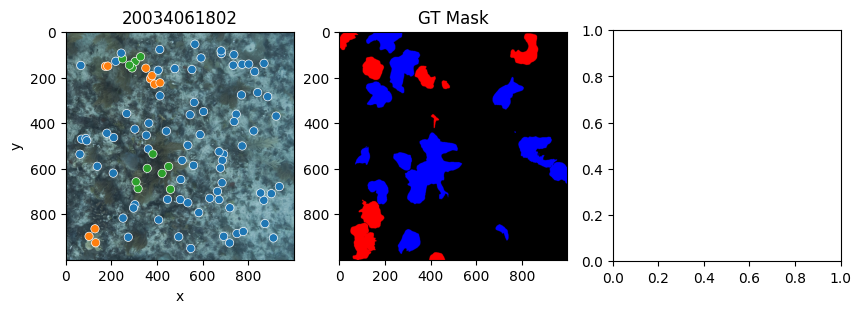

In [47]:
index = 0
visualize_output(**label_prop_data[index])

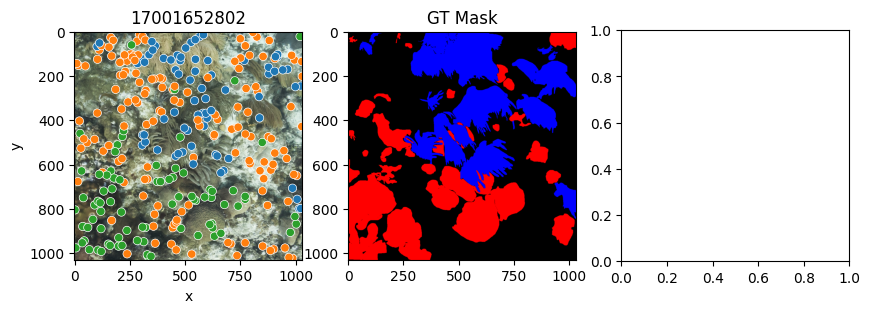

In [ ]:
index = 0
visualize_output(**label_prop_data[index])

## Hyper Params Range Setup

In [48]:
# define ranges for each hyper parameter
point_labels_type_range = ['SPARSE']
num_spixels_range = [400]
ensemble_range = ['No']
alpha_range = [0, 0.01, 0.1, 1, 10, 100, 1_000, 10_000]
xysigma_range = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
cnnsigma_range = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

# create a dictionary listing all hyper parameters and their ranges
hyper_params_ranges = {
    'point_labels_type': point_labels_type_range,
    'num_spixels': num_spixels_range,
    'ensemble': ensemble_range,
    'alpha': alpha_range,
    'xysigma': xysigma_range,
    'cnnsigma': cnnsigma_range,
}

hyper_params_ranges

{'point_labels_type': ['SPARSE'],
 'num_spixels': [400],
 'ensemble': ['No'],
 'alpha': [0, 0.01, 0.1, 1, 10, 100, 1000, 10000],
 'xysigma': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
 'cnnsigma': [0.05, 0.1, 0.25, 0.5, 0.75, 1]}

## Grid Search

In [49]:
grid_search_plaspix = \
    PLASPIXLabelPropGridSearch(
        dataloader=label_prop_data,
        hyper_params_ranges=hyper_params_ranges,
        save_path=Path(RESULTS_UPLOAD_PATH),
        restart_index=111,
        save_interval=10,
        )

In [ ]:
grid_search_plaspix.process_all_combinations()

Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/labels', save_labels='/content/labelprop/predictions', save_rgb=None, ensemble=False, points=True, xysigma=0.05, cnnsigma=0.25, alpha=1.0, num_labels=300, image_height=512, image_width=512, num_classes=4, unlabeled=3, num_spixels=400)
received your values, setting some things up...
setup is complete, now iterating through your images...


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C111', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.05, 'cnnsigma': 0.25, 'pa': 0.8893113136291504, 'mpa': 0.7478833198547363, 'pa_class_0': 0.9408619999885559, 'pa_class_1': 0.6936838626861572, 'pa_class_2': 0.6091040372848511, 'miou': 0.6311001181602478, 'iou_class_0': 0.8757529258728027, 'iou_class_1': 0.5651261806488037, 'iou_class_2': 0.4524211883544922}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Cora

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C112', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.05, 'cnnsigma': 0.5, 'pa': 0.8939005136489868, 'mpa': 0.7539053559303284, 'pa_class_0': 0.9441142678260803, 'pa_class_1': 0.7116875052452087, 'pa_class_2': 0.6059143543243408, 'miou': 0.6426746845245361, 'iou_class_0': 0.8803511261940002, 'iou_class_1': 0.5747498869895935, 'iou_class_2': 0.47292304039001465}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C113', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.05, 'cnnsigma': 0.75, 'pa': 0.8893402218818665, 'mpa': 0.7554322481155396, 'pa_class_0': 0.9361702799797058, 'pa_class_1': 0.7318967580795288, 'pa_class_2': 0.5982296466827393, 'miou': 0.6345484852790833, 'iou_class_0': 0.8753777742385864, 'iou_class_1': 0.5711328387260437, 'iou_class_2': 0.45713484287261963}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C114', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.05, 'cnnsigma': 1, 'pa': 0.8953601717948914, 'mpa': 0.7639986276626587, 'pa_class_0': 0.9427083730697632, 'pa_class_1': 0.7211406230926514, 'pa_class_2': 0.6281468868255615, 'miou': 0.6483334302902222, 'iou_class_0': 0.8820053935050964, 'iou_class_1': 0.5856425166130066, 'iou_class_2': 0.47735244035720825}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C115', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.1, 'cnnsigma': 0.05, 'pa': 0.8982892036437988, 'mpa': 0.7599183320999146, 'pa_class_0': 0.9486973881721497, 'pa_class_1': 0.7072851657867432, 'pa_class_2': 0.6237724423408508, 'miou': 0.6539510488510132, 'iou_class_0': 0.8855064511299133, 'iou_class_1': 0.5759419798851013, 'iou_class_2': 0.5004047751426697}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C116', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.1, 'cnnsigma': 0.1, 'pa': 0.8953588008880615, 'mpa': 0.7764954566955566, 'pa_class_0': 0.9392694234848022, 'pa_class_1': 0.7227357029914856, 'pa_class_2': 0.6674813032150269, 'miou': 0.6572644114494324, 'iou_class_0': 0.8814776539802551, 'iou_class_1': 0.5655426383018494, 'iou_class_2': 0.5247730016708374}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C117', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.1, 'cnnsigma': 0.25, 'pa': 0.8881303071975708, 'mpa': 0.7646740674972534, 'pa_class_0': 0.9325059056282043, 'pa_class_1': 0.7261238694190979, 'pa_class_2': 0.6353924870491028, 'miou': 0.6371768712997437, 'iou_class_0': 0.873829185962677, 'iou_class_1': 0.5617067813873291, 'iou_class_2': 0.47599461674690247}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C118', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.1, 'cnnsigma': 0.5, 'pa': 0.8929107189178467, 'mpa': 0.7585194110870361, 'pa_class_0': 0.940436840057373, 'pa_class_1': 0.727502703666687, 'pa_class_2': 0.6076186299324036, 'miou': 0.6415246725082397, 'iou_class_0': 0.8790635466575623, 'iou_class_1': 0.5858861804008484, 'iou_class_2': 0.45962435007095337}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C119', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.1, 'cnnsigma': 0.75, 'pa': 0.8916499018669128, 'mpa': 0.7595884203910828, 'pa_class_0': 0.9398795366287231, 'pa_class_1': 0.7076713442802429, 'pa_class_2': 0.6312144994735718, 'miou': 0.6427799463272095, 'iou_class_0': 0.878214418888092, 'iou_class_1': 0.554335355758667, 'iou_class_2': 0.49579012393951416}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C120', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.1, 'cnnsigma': 1, 'pa': 0.8877021074295044, 'mpa': 0.7712271809577942, 'pa_class_0': 0.9289914965629578, 'pa_class_1': 0.7429524064064026, 'pa_class_2': 0.6417376399040222, 'miou': 0.6386991143226624, 'iou_class_0': 0.872893750667572, 'iou_class_1': 0.5690171718597412, 'iou_class_2': 0.47418642044067383}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/l

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C121', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.25, 'cnnsigma': 0.05, 'pa': 0.8916776180267334, 'mpa': 0.7674463987350464, 'pa_class_0': 0.9356786012649536, 'pa_class_1': 0.7378215193748474, 'pa_class_2': 0.6288390159606934, 'miou': 0.645762026309967, 'iou_class_0': 0.8791652321815491, 'iou_class_1': 0.5547184944152832, 'iou_class_2': 0.5034023523330688}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C122', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.25, 'cnnsigma': 0.1, 'pa': 0.8915237784385681, 'mpa': 0.7612422704696655, 'pa_class_0': 0.9385724067687988, 'pa_class_1': 0.7174777388572693, 'pa_class_2': 0.6276765465736389, 'miou': 0.6418856978416443, 'iou_class_0': 0.8773093819618225, 'iou_class_1': 0.5701096057891846, 'iou_class_2': 0.4782380759716034}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C123', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.25, 'cnnsigma': 0.25, 'pa': 0.8937180638313293, 'mpa': 0.7590827345848083, 'pa_class_0': 0.9408797025680542, 'pa_class_1': 0.7343359589576721, 'pa_class_2': 0.6020326018333435, 'miou': 0.6454586982727051, 'iou_class_0': 0.8799070715904236, 'iou_class_1': 0.5736139416694641, 'iou_class_2': 0.48285502195358276}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C124', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.25, 'cnnsigma': 0.5, 'pa': 0.8928762674331665, 'mpa': 0.7636278867721558, 'pa_class_0': 0.9386487603187561, 'pa_class_1': 0.7328844666481018, 'pa_class_2': 0.6193503141403198, 'miou': 0.6439191699028015, 'iou_class_0': 0.87935870885849, 'iou_class_1': 0.57884681224823, 'iou_class_2': 0.47355201840400696}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/l

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C125', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.25, 'cnnsigma': 0.75, 'pa': 0.887105405330658, 'mpa': 0.7512376308441162, 'pa_class_0': 0.9336254596710205, 'pa_class_1': 0.7413276433944702, 'pa_class_2': 0.5787596702575684, 'miou': 0.6294040679931641, 'iou_class_0': 0.8727135062217712, 'iou_class_1': 0.5663878917694092, 'iou_class_2': 0.44911089539527893}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C126', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.25, 'cnnsigma': 1, 'pa': 0.891316294670105, 'mpa': 0.7577884793281555, 'pa_class_0': 0.9386904239654541, 'pa_class_1': 0.7248176336288452, 'pa_class_2': 0.6098572015762329, 'miou': 0.6385139226913452, 'iou_class_0': 0.877511739730835, 'iou_class_1': 0.5786070823669434, 'iou_class_2': 0.4594229757785797}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/la

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C127', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.5, 'cnnsigma': 0.05, 'pa': 0.89310622215271, 'mpa': 0.7316732406616211, 'pa_class_0': 0.9477373361587524, 'pa_class_1': 0.7289121150970459, 'pa_class_2': 0.5183700919151306, 'miou': 0.6299466490745544, 'iou_class_0': 0.8803156018257141, 'iou_class_1': 0.5782853960990906, 'iou_class_2': 0.43123894929885864}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C128', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.5, 'cnnsigma': 0.1, 'pa': 0.8983384370803833, 'mpa': 0.7446002960205078, 'pa_class_0': 0.9513512849807739, 'pa_class_1': 0.7281356453895569, 'pa_class_2': 0.5543138980865479, 'miou': 0.6444187760353088, 'iou_class_0': 0.8858926296234131, 'iou_class_1': 0.5979982614517212, 'iou_class_2': 0.4493655562400818}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C129', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.5, 'cnnsigma': 0.25, 'pa': 0.898525595664978, 'mpa': 0.7577282190322876, 'pa_class_0': 0.9462442398071289, 'pa_class_1': 0.7543249130249023, 'pa_class_2': 0.5726155042648315, 'miou': 0.6515101790428162, 'iou_class_0': 0.8852216005325317, 'iou_class_1': 0.5999600887298584, 'iou_class_2': 0.46934887766838074}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C130', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.5, 'cnnsigma': 0.5, 'pa': 0.8929442763328552, 'mpa': 0.7523620128631592, 'pa_class_0': 0.9421897530555725, 'pa_class_1': 0.7265124917030334, 'pa_class_2': 0.5883837938308716, 'miou': 0.6406654715538025, 'iou_class_0': 0.8783186078071594, 'iou_class_1': 0.5824550986289978, 'iou_class_2': 0.46122270822525024}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C131', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.5, 'cnnsigma': 0.75, 'pa': 0.8939730525016785, 'mpa': 0.7552838325500488, 'pa_class_0': 0.9429641962051392, 'pa_class_1': 0.7240444421768188, 'pa_class_2': 0.5988429188728333, 'miou': 0.6422814130783081, 'iou_class_0': 0.8798599243164062, 'iou_class_1': 0.5919221043586731, 'iou_class_2': 0.4550621509552002}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C132', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.5, 'cnnsigma': 1, 'pa': 0.8820827603340149, 'mpa': 0.7419943809509277, 'pa_class_0': 0.9313074946403503, 'pa_class_1': 0.7140986323356628, 'pa_class_2': 0.58057701587677, 'miou': 0.6160155534744263, 'iou_class_0': 0.867509126663208, 'iou_class_1': 0.5616829991340637, 'iou_class_2': 0.41885465383529663}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/lab

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C133', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.75, 'cnnsigma': 0.05, 'pa': 0.8925483822822571, 'mpa': 0.750359296798706, 'pa_class_0': 0.9418701529502869, 'pa_class_1': 0.7310435175895691, 'pa_class_2': 0.578164279460907, 'miou': 0.6361174583435059, 'iou_class_0': 0.8817132711410522, 'iou_class_1': 0.5646783709526062, 'iou_class_2': 0.46196073293685913}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C134', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.75, 'cnnsigma': 0.1, 'pa': 0.8934385180473328, 'mpa': 0.7738873362541199, 'pa_class_0': 0.9370565414428711, 'pa_class_1': 0.7274895310401917, 'pa_class_2': 0.6571159958839417, 'miou': 0.6518332362174988, 'iou_class_0': 0.8805575370788574, 'iou_class_1': 0.5577658414840698, 'iou_class_2': 0.5171763300895691}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C135', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.75, 'cnnsigma': 0.25, 'pa': 0.897855818271637, 'mpa': 0.7663344144821167, 'pa_class_0': 0.9429585337638855, 'pa_class_1': 0.7557475566864014, 'pa_class_2': 0.6002970933914185, 'miou': 0.652694582939148, 'iou_class_0': 0.8851982951164246, 'iou_class_1': 0.5983923673629761, 'iou_class_2': 0.4744930863380432}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C136', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.75, 'cnnsigma': 0.5, 'pa': 0.9021202325820923, 'mpa': 0.7690049409866333, 'pa_class_0': 0.9490239024162292, 'pa_class_1': 0.7406856417655945, 'pa_class_2': 0.6173052191734314, 'miou': 0.6620861291885376, 'iou_class_0': 0.8899698853492737, 'iou_class_1': 0.6045128703117371, 'iou_class_2': 0.49177566170692444}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C137', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.75, 'cnnsigma': 0.75, 'pa': 0.8906779289245605, 'mpa': 0.7477065324783325, 'pa_class_0': 0.9426127076148987, 'pa_class_1': 0.6954200267791748, 'pa_class_2': 0.6050868034362793, 'miou': 0.631828248500824, 'iou_class_0': 0.8778923749923706, 'iou_class_1': 0.576761782169342, 'iou_class_2': 0.4408305883407593}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C138', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 0.75, 'cnnsigma': 1, 'pa': 0.8883382081985474, 'mpa': 0.7498607635498047, 'pa_class_0': 0.9381474256515503, 'pa_class_1': 0.7061381936073303, 'pa_class_2': 0.6052966713905334, 'miou': 0.6309570670127869, 'iou_class_0': 0.8748099207878113, 'iou_class_1': 0.5574655532836914, 'iou_class_2': 0.4605956971645355}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C139', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 1, 'cnnsigma': 0.05, 'pa': 0.8939312100410461, 'mpa': 0.7394666075706482, 'pa_class_0': 0.9497407674789429, 'pa_class_1': 0.687188982963562, 'pa_class_2': 0.5814700722694397, 'miou': 0.6373966336250305, 'iou_class_0': 0.8816434144973755, 'iou_class_1': 0.5556368827819824, 'iou_class_2': 0.47490957379341125}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C140', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 1, 'cnnsigma': 0.1, 'pa': 0.8930590152740479, 'mpa': 0.7397786974906921, 'pa_class_0': 0.9460934996604919, 'pa_class_1': 0.7208443880081177, 'pa_class_2': 0.5523982644081116, 'miou': 0.6363168954849243, 'iou_class_0': 0.8804882764816284, 'iou_class_1': 0.559477686882019, 'iou_class_2': 0.4689846336841583}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/la

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C141', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 1, 'cnnsigma': 0.25, 'pa': 0.8918706178665161, 'mpa': 0.7363454103469849, 'pa_class_0': 0.945263147354126, 'pa_class_1': 0.7230096459388733, 'pa_class_2': 0.5407633185386658, 'miou': 0.6313848495483398, 'iou_class_0': 0.8785749077796936, 'iou_class_1': 0.5691645741462708, 'iou_class_2': 0.4464150667190552}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/l

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C142', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 1, 'cnnsigma': 0.5, 'pa': 0.9055067300796509, 'mpa': 0.7636548280715942, 'pa_class_0': 0.9580594897270203, 'pa_class_1': 0.6973963379859924, 'pa_class_2': 0.6355085968971252, 'miou': 0.6675034761428833, 'iou_class_0': 0.8937950134277344, 'iou_class_1': 0.5996680855751038, 'iou_class_2': 0.509047269821167}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/la

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C143', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 1, 'cnnsigma': 0.75, 'pa': 0.8923000693321228, 'mpa': 0.7475407719612122, 'pa_class_0': 0.941551148891449, 'pa_class_1': 0.7413796186447144, 'pa_class_2': 0.5596915483474731, 'miou': 0.6359934210777283, 'iou_class_0': 0.8785430192947388, 'iou_class_1': 0.5828813314437866, 'iou_class_2': 0.446556031703949}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/la

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C144', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 1, 'xysigma': 1, 'cnnsigma': 1, 'pa': 0.8938624262809753, 'mpa': 0.7464590072631836, 'pa_class_0': 0.9464482665061951, 'pa_class_1': 0.7060095071792603, 'pa_class_2': 0.5869191884994507, 'miou': 0.6385079026222229, 'iou_class_0': 0.8802793622016907, 'iou_class_1': 0.5835356116294861, 'iou_class_2': 0.4517086148262024}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/lab

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C145', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.05, 'cnnsigma': 0.05, 'pa': 0.8977062106132507, 'mpa': 0.7636759877204895, 'pa_class_0': 0.944845974445343, 'pa_class_1': 0.7363724708557129, 'pa_class_2': 0.6098095774650574, 'miou': 0.6496294140815735, 'iou_class_0': 0.8852702379226685, 'iou_class_1': 0.612454354763031, 'iou_class_2': 0.4511635899543762}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C146', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.05, 'cnnsigma': 0.1, 'pa': 0.9050504565238953, 'mpa': 0.7795063257217407, 'pa_class_0': 0.9485797882080078, 'pa_class_1': 0.762713611125946, 'pa_class_2': 0.6272255778312683, 'miou': 0.672741711139679, 'iou_class_0': 0.8918023705482483, 'iou_class_1': 0.6230332255363464, 'iou_class_2': 0.5033895373344421}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C147', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.05, 'cnnsigma': 0.25, 'pa': 0.8960984349250793, 'mpa': 0.7483440041542053, 'pa_class_0': 0.9478854537010193, 'pa_class_1': 0.7207668423652649, 'pa_class_2': 0.5763797163963318, 'miou': 0.643510639667511, 'iou_class_0': 0.8829770684242249, 'iou_class_1': 0.5851491689682007, 'iou_class_2': 0.46240565180778503}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C148', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.05, 'cnnsigma': 0.5, 'pa': 0.8912649750709534, 'mpa': 0.7546963691711426, 'pa_class_0': 0.9400799870491028, 'pa_class_1': 0.7158933877944946, 'pa_class_2': 0.6081157326698303, 'miou': 0.6364409327507019, 'iou_class_0': 0.8778252005577087, 'iou_class_1': 0.5802799463272095, 'iou_class_2': 0.4512177109718323}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C149', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.05, 'cnnsigma': 0.75, 'pa': 0.8932685256004333, 'mpa': 0.7610140442848206, 'pa_class_0': 0.9393006563186646, 'pa_class_1': 0.7408515214920044, 'pa_class_2': 0.602889895439148, 'miou': 0.6420864462852478, 'iou_class_0': 0.8798810839653015, 'iou_class_1': 0.5916997194290161, 'iou_class_2': 0.4546785354614258}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C150', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.05, 'cnnsigma': 1, 'pa': 0.8846288323402405, 'mpa': 0.7465001940727234, 'pa_class_0': 0.932880699634552, 'pa_class_1': 0.7229840755462646, 'pa_class_2': 0.5836357474327087, 'miou': 0.6215367913246155, 'iou_class_0': 0.87051922082901, 'iou_class_1': 0.5696984529495239, 'iou_class_2': 0.4243926405906677}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/la

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C151', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.1, 'cnnsigma': 0.05, 'pa': 0.8982598781585693, 'mpa': 0.7603228092193604, 'pa_class_0': 0.9467608332633972, 'pa_class_1': 0.7324042320251465, 'pa_class_2': 0.6018033623695374, 'miou': 0.6525284051895142, 'iou_class_0': 0.8847641348838806, 'iou_class_1': 0.5967235565185547, 'iou_class_2': 0.47609761357307434}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C152', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.1, 'cnnsigma': 0.1, 'pa': 0.9012008309364319, 'mpa': 0.7711730003356934, 'pa_class_0': 0.949461042881012, 'pa_class_1': 0.7092028856277466, 'pa_class_2': 0.6548550724983215, 'miou': 0.6623691916465759, 'iou_class_0': 0.888864278793335, 'iou_class_1': 0.5898107290267944, 'iou_class_2': 0.5084325075149536}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C153', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.1, 'cnnsigma': 0.25, 'pa': 0.8942061066627502, 'mpa': 0.7574840188026428, 'pa_class_0': 0.9431890249252319, 'pa_class_1': 0.717051088809967, 'pa_class_2': 0.6122118830680847, 'miou': 0.6438397169113159, 'iou_class_0': 0.8801349997520447, 'iou_class_1': 0.5891659259796143, 'iou_class_2': 0.46221834421157837}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C154', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.1, 'cnnsigma': 0.5, 'pa': 0.8958772420883179, 'mpa': 0.7700598239898682, 'pa_class_0': 0.9417160749435425, 'pa_class_1': 0.7221473455429077, 'pa_class_2': 0.6463159918785095, 'miou': 0.6500941514968872, 'iou_class_0': 0.8829163312911987, 'iou_class_1': 0.5962128043174744, 'iou_class_2': 0.4711533486843109}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C155', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.1, 'cnnsigma': 0.75, 'pa': 0.8950260877609253, 'mpa': 0.7671362161636353, 'pa_class_0': 0.9400404691696167, 'pa_class_1': 0.7406023144721985, 'pa_class_2': 0.6207658052444458, 'miou': 0.6481732130050659, 'iou_class_0': 0.8817950487136841, 'iou_class_1': 0.5912442803382874, 'iou_class_2': 0.4714803695678711}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C156', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.1, 'cnnsigma': 1, 'pa': 0.8865497708320618, 'mpa': 0.7677415013313293, 'pa_class_0': 0.9307845234870911, 'pa_class_1': 0.7091723680496216, 'pa_class_2': 0.6632676124572754, 'miou': 0.6330734491348267, 'iou_class_0': 0.8736366629600525, 'iou_class_1': 0.5572338700294495, 'iou_class_2': 0.4683499038219452}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C157', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.25, 'cnnsigma': 0.05, 'pa': 0.8865371346473694, 'mpa': 0.719140350818634, 'pa_class_0': 0.9433159232139587, 'pa_class_1': 0.7144609093666077, 'pa_class_2': 0.49964427947998047, 'miou': 0.6129001379013062, 'iou_class_0': 0.8735573887825012, 'iou_class_1': 0.5599385499954224, 'iou_class_2': 0.4052044749259949}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C158', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.25, 'cnnsigma': 0.1, 'pa': 0.900978684425354, 'mpa': 0.792349100112915, 'pa_class_0': 0.9412192702293396, 'pa_class_1': 0.7416667938232422, 'pa_class_2': 0.6941612362861633, 'miou': 0.6726387739181519, 'iou_class_0': 0.8879154324531555, 'iou_class_1': 0.5851982235908508, 'iou_class_2': 0.5448026061058044}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C159', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.25, 'cnnsigma': 0.25, 'pa': 0.896735668182373, 'mpa': 0.7765814065933228, 'pa_class_0': 0.940528929233551, 'pa_class_1': 0.7305781245231628, 'pa_class_2': 0.6586371660232544, 'miou': 0.6558587551116943, 'iou_class_0': 0.883168637752533, 'iou_class_1': 0.5917566418647766, 'iou_class_2': 0.4926510155200958}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C160', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.25, 'cnnsigma': 0.5, 'pa': 0.8992478847503662, 'mpa': 0.7700055241584778, 'pa_class_0': 0.9462191462516785, 'pa_class_1': 0.7224081158638, 'pa_class_2': 0.6413893699645996, 'miou': 0.6589444875717163, 'iou_class_0': 0.8849414587020874, 'iou_class_1': 0.6026676893234253, 'iou_class_2': 0.48922428488731384}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C161', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.25, 'cnnsigma': 0.75, 'pa': 0.8831617832183838, 'mpa': 0.7398532629013062, 'pa_class_0': 0.933941662311554, 'pa_class_1': 0.7053699493408203, 'pa_class_2': 0.5802481174468994, 'miou': 0.6197858452796936, 'iou_class_0': 0.8683980703353882, 'iou_class_1': 0.5424052476882935, 'iou_class_2': 0.4485541582107544}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C162', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.25, 'cnnsigma': 1, 'pa': 0.88581782579422, 'mpa': 0.7492944598197937, 'pa_class_0': 0.9327580332756042, 'pa_class_1': 0.7365903258323669, 'pa_class_2': 0.5785349011421204, 'miou': 0.626327633857727, 'iou_class_0': 0.8708305358886719, 'iou_class_1': 0.5686464905738831, 'iou_class_2': 0.43950578570365906}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/l

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C163', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.5, 'cnnsigma': 0.05, 'pa': 0.901584267616272, 'mpa': 0.7343608736991882, 'pa_class_0': 0.9610096216201782, 'pa_class_1': 0.6917166709899902, 'pa_class_2': 0.5503561496734619, 'miou': 0.6458307504653931, 'iou_class_0': 0.890488862991333, 'iou_class_1': 0.5935789346694946, 'iou_class_2': 0.4534244239330292}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C164', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.5, 'cnnsigma': 0.1, 'pa': 0.8935942053794861, 'mpa': 0.7537764310836792, 'pa_class_0': 0.9419379830360413, 'pa_class_1': 0.7369641661643982, 'pa_class_2': 0.5824271440505981, 'miou': 0.6424810290336609, 'iou_class_0': 0.8807156085968018, 'iou_class_1': 0.5691500306129456, 'iou_class_2': 0.4775775074958801}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C165', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.5, 'cnnsigma': 0.25, 'pa': 0.8996421694755554, 'mpa': 0.767238438129425, 'pa_class_0': 0.9456166625022888, 'pa_class_1': 0.7485916614532471, 'pa_class_2': 0.6075069904327393, 'miou': 0.6582088470458984, 'iou_class_0': 0.8860751986503601, 'iou_class_1': 0.6013253927230835, 'iou_class_2': 0.4872259497642517}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C166', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.5, 'cnnsigma': 0.5, 'pa': 0.8933679461479187, 'mpa': 0.7482426762580872, 'pa_class_0': 0.9440706372261047, 'pa_class_1': 0.7234412431716919, 'pa_class_2': 0.5772162079811096, 'miou': 0.6376830339431763, 'iou_class_0': 0.8788065314292908, 'iou_class_1': 0.608619213104248, 'iou_class_2': 0.4256233274936676}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C167', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.5, 'cnnsigma': 0.75, 'pa': 0.8930672407150269, 'mpa': 0.7371513247489929, 'pa_class_0': 0.9487990736961365, 'pa_class_1': 0.6928331255912781, 'pa_class_2': 0.5698217153549194, 'miou': 0.6320490837097168, 'iou_class_0': 0.8800300359725952, 'iou_class_1': 0.5865246653556824, 'iou_class_2': 0.4295925796031952}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C168', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.5, 'cnnsigma': 1, 'pa': 0.8915314674377441, 'mpa': 0.7473405599594116, 'pa_class_0': 0.9445198178291321, 'pa_class_1': 0.6860386729240417, 'pa_class_2': 0.611463189125061, 'miou': 0.6349265575408936, 'iou_class_0': 0.8775227069854736, 'iou_class_1': 0.5774585604667664, 'iou_class_2': 0.44979849457740784}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C169', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.75, 'cnnsigma': 0.05, 'pa': 0.901168942451477, 'mpa': 0.7438751459121704, 'pa_class_0': 0.9561126828193665, 'pa_class_1': 0.7171385884284973, 'pa_class_2': 0.558374285697937, 'miou': 0.650121808052063, 'iou_class_0': 0.8902799487113953, 'iou_class_1': 0.5850324630737305, 'iou_class_2': 0.47505295276641846}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C170', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.75, 'cnnsigma': 0.1, 'pa': 0.890413224697113, 'mpa': 0.7553509473800659, 'pa_class_0': 0.939201295375824, 'pa_class_1': 0.7097978591918945, 'pa_class_2': 0.6170536875724792, 'miou': 0.6367790102958679, 'iou_class_0': 0.8778753280639648, 'iou_class_1': 0.5552083253860474, 'iou_class_2': 0.47725340723991394}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C171', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.75, 'cnnsigma': 0.25, 'pa': 0.901434063911438, 'mpa': 0.7781165838241577, 'pa_class_0': 0.9465017914772034, 'pa_class_1': 0.7291959524154663, 'pa_class_2': 0.6586520075798035, 'miou': 0.6650779247283936, 'iou_class_0': 0.8892446160316467, 'iou_class_1': 0.5947662591934204, 'iou_class_2': 0.511222779750824}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C172', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.75, 'cnnsigma': 0.5, 'pa': 0.8948282599449158, 'mpa': 0.7567420601844788, 'pa_class_0': 0.9426863193511963, 'pa_class_1': 0.7385517954826355, 'pa_class_2': 0.5889880657196045, 'miou': 0.6436007022857666, 'iou_class_0': 0.8812838196754456, 'iou_class_1': 0.5952432751655579, 'iou_class_2': 0.4542750418186188}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C173', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.75, 'cnnsigma': 0.75, 'pa': 0.9021295309066772, 'mpa': 0.751722514629364, 'pa_class_0': 0.9547985792160034, 'pa_class_1': 0.7243183851242065, 'pa_class_2': 0.5760507583618164, 'miou': 0.6550309062004089, 'iou_class_0': 0.890069305896759, 'iou_class_1': 0.603066086769104, 'iou_class_2': 0.47195732593536377}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C174', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 0.75, 'cnnsigma': 1, 'pa': 0.9001979827880859, 'mpa': 0.7514078617095947, 'pa_class_0': 0.953940749168396, 'pa_class_1': 0.7012836933135986, 'pa_class_2': 0.5989992022514343, 'miou': 0.6505996584892273, 'iou_class_0': 0.8882840275764465, 'iou_class_1': 0.5987086892127991, 'iou_class_2': 0.46480631828308105}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C175', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 1, 'cnnsigma': 0.05, 'pa': 0.8860924243927002, 'mpa': 0.7578917741775513, 'pa_class_0': 0.9324894547462463, 'pa_class_1': 0.7134244441986084, 'pa_class_2': 0.6277613639831543, 'miou': 0.6316598057746887, 'iou_class_0': 0.8728103637695312, 'iou_class_1': 0.5416063070297241, 'iou_class_2': 0.4805627763271332}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C176', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 1, 'cnnsigma': 0.1, 'pa': 0.8904899954795837, 'mpa': 0.7453462481498718, 'pa_class_0': 0.9413825273513794, 'pa_class_1': 0.7179670333862305, 'pa_class_2': 0.5766893029212952, 'miou': 0.6325708627700806, 'iou_class_0': 0.8773987889289856, 'iou_class_1': 0.5639058947563171, 'iou_class_2': 0.4564078450202942}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C177', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 1, 'cnnsigma': 0.25, 'pa': 0.9016473889350891, 'mpa': 0.757891833782196, 'pa_class_0': 0.9523574709892273, 'pa_class_1': 0.7265042662620544, 'pa_class_2': 0.5948137640953064, 'miou': 0.6578353047370911, 'iou_class_0': 0.8892605900764465, 'iou_class_1': 0.5968513488769531, 'iou_class_2': 0.4873940050601959}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C178', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 1, 'cnnsigma': 0.5, 'pa': 0.9034997820854187, 'mpa': 0.7718036770820618, 'pa_class_0': 0.9510945677757263, 'pa_class_1': 0.7270678877830505, 'pa_class_2': 0.6372485756874084, 'miou': 0.6683122515678406, 'iou_class_0': 0.8919796943664551, 'iou_class_1': 0.5871626734733582, 'iou_class_2': 0.5257943272590637}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C179', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 1, 'cnnsigma': 0.75, 'pa': 0.9016680121421814, 'mpa': 0.738818883895874, 'pa_class_0': 0.9578366279602051, 'pa_class_1': 0.7211819291114807, 'pa_class_2': 0.5374382138252258, 'miou': 0.6492164134979248, 'iou_class_0': 0.8899011015892029, 'iou_class_1': 0.5934447646141052, 'iou_class_2': 0.46430349349975586}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C180', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 10, 'xysigma': 1, 'cnnsigma': 1, 'pa': 0.8942979574203491, 'mpa': 0.7280751466751099, 'pa_class_0': 0.952318012714386, 'pa_class_1': 0.7004197835922241, 'pa_class_2': 0.5314875245094299, 'miou': 0.6310701370239258, 'iou_class_0': 0.8813562393188477, 'iou_class_1': 0.5794787406921387, 'iou_class_2': 0.432375431060791}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/labe

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C181', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.05, 'cnnsigma': 0.05, 'pa': 0.9013545513153076, 'mpa': 0.7835395336151123, 'pa_class_0': 0.9449390769004822, 'pa_class_1': 0.7293956875801086, 'pa_class_2': 0.6762838363647461, 'miou': 0.6661930084228516, 'iou_class_0': 0.8889382481575012, 'iou_class_1': 0.601569652557373, 'iou_class_2': 0.5080711841583252}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C182', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.05, 'cnnsigma': 0.1, 'pa': 0.8937095999717712, 'mpa': 0.74761962890625, 'pa_class_0': 0.9454872608184814, 'pa_class_1': 0.7122964859008789, 'pa_class_2': 0.5850750207901001, 'miou': 0.6380475163459778, 'iou_class_0': 0.881951093673706, 'iou_class_1': 0.5680216550827026, 'iou_class_2': 0.46416983008384705}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C183', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.05, 'cnnsigma': 0.25, 'pa': 0.8893112540245056, 'mpa': 0.7651377320289612, 'pa_class_0': 0.9330920577049255, 'pa_class_1': 0.7383298277854919, 'pa_class_2': 0.6239912509918213, 'miou': 0.6386534571647644, 'iou_class_0': 0.8757340312004089, 'iou_class_1': 0.5657642483711243, 'iou_class_2': 0.4744621813297272}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/label

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C184', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.05, 'cnnsigma': 0.5, 'pa': 0.8913237452507019, 'mpa': 0.768042266368866, 'pa_class_0': 0.9355244040489197, 'pa_class_1': 0.7311202883720398, 'pa_class_2': 0.637482225894928, 'miou': 0.6405549049377441, 'iou_class_0': 0.8782408833503723, 'iou_class_1': 0.5886688828468323, 'iou_class_2': 0.45475491881370544}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C185', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.05, 'cnnsigma': 0.75, 'pa': 0.888226330280304, 'mpa': 0.7512375712394714, 'pa_class_0': 0.9377416968345642, 'pa_class_1': 0.7045943140983582, 'pa_class_2': 0.6113768815994263, 'miou': 0.6294500231742859, 'iou_class_0': 0.87571120262146, 'iou_class_1': 0.5602703094482422, 'iou_class_2': 0.45236846804618835}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C186', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.05, 'cnnsigma': 1, 'pa': 0.8909743428230286, 'mpa': 0.7466988563537598, 'pa_class_0': 0.9409278035163879, 'pa_class_1': 0.7283914089202881, 'pa_class_2': 0.5707772970199585, 'miou': 0.631401002407074, 'iou_class_0': 0.8782019019126892, 'iou_class_1': 0.5837197303771973, 'iou_class_2': 0.43228140473365784}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C187', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.1, 'cnnsigma': 0.05, 'pa': 0.8937910795211792, 'mpa': 0.7512564659118652, 'pa_class_0': 0.94511479139328, 'pa_class_1': 0.7054789066314697, 'pa_class_2': 0.603175699710846, 'miou': 0.6406120657920837, 'iou_class_0': 0.8807427883148193, 'iou_class_1': 0.5739801526069641, 'iou_class_2': 0.46711328625679016}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpro

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C188', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.1, 'cnnsigma': 0.1, 'pa': 0.8958058953285217, 'mpa': 0.7618621587753296, 'pa_class_0': 0.9421823620796204, 'pa_class_1': 0.7448618412017822, 'pa_class_2': 0.5985422134399414, 'miou': 0.6470391154289246, 'iou_class_0': 0.8835389018058777, 'iou_class_1': 0.5873497724533081, 'iou_class_2': 0.4702287018299103}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C189', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.1, 'cnnsigma': 0.25, 'pa': 0.8986985683441162, 'mpa': 0.7684673070907593, 'pa_class_0': 0.9461808800697327, 'pa_class_1': 0.718377947807312, 'pa_class_2': 0.6408430933952332, 'miou': 0.6570486426353455, 'iou_class_0': 0.8858553171157837, 'iou_class_1': 0.5853421688079834, 'iou_class_2': 0.49994832277297974}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C190', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.1, 'cnnsigma': 0.5, 'pa': 0.8935157656669617, 'mpa': 0.769191563129425, 'pa_class_0': 0.9383514523506165, 'pa_class_1': 0.7282924056053162, 'pa_class_2': 0.6409308910369873, 'miou': 0.6463543772697449, 'iou_class_0': 0.87991863489151, 'iou_class_1': 0.5880066156387329, 'iou_class_2': 0.4711378514766693}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C191', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.1, 'cnnsigma': 0.75, 'pa': 0.8892781734466553, 'mpa': 0.751718282699585, 'pa_class_0': 0.9374247193336487, 'pa_class_1': 0.7269886136054993, 'pa_class_2': 0.5907414555549622, 'miou': 0.632396936416626, 'iou_class_0': 0.8749858736991882, 'iou_class_1': 0.5790992975234985, 'iou_class_2': 0.44310569763183594}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C192', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.1, 'cnnsigma': 1, 'pa': 0.8953849673271179, 'mpa': 0.7572563886642456, 'pa_class_0': 0.9447867274284363, 'pa_class_1': 0.717601478099823, 'pa_class_2': 0.6093809008598328, 'miou': 0.6457916498184204, 'iou_class_0': 0.8826369643211365, 'iou_class_1': 0.5784670114517212, 'iou_class_2': 0.4762710630893707}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C193', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.25, 'cnnsigma': 0.05, 'pa': 0.8877581357955933, 'mpa': 0.7428097128868103, 'pa_class_0': 0.9373956322669983, 'pa_class_1': 0.7321203947067261, 'pa_class_2': 0.5589131116867065, 'miou': 0.6261305212974548, 'iou_class_0': 0.8740841746330261, 'iou_class_1': 0.5668104290962219, 'iou_class_2': 0.43749693036079407}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labe

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C194', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.25, 'cnnsigma': 0.1, 'pa': 0.8949092626571655, 'mpa': 0.7709603905677795, 'pa_class_0': 0.938136637210846, 'pa_class_1': 0.7508559226989746, 'pa_class_2': 0.6238885521888733, 'miou': 0.6542011499404907, 'iou_class_0': 0.8802400827407837, 'iou_class_1': 0.5773325562477112, 'iou_class_2': 0.5050308704376221}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C195', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.25, 'cnnsigma': 0.25, 'pa': 0.896393895149231, 'mpa': 0.7548884749412537, 'pa_class_0': 0.9451987743377686, 'pa_class_1': 0.7395906448364258, 'pa_class_2': 0.5798760056495667, 'miou': 0.6437718272209167, 'iou_class_0': 0.8836560249328613, 'iou_class_1': 0.6111104488372803, 'iou_class_2': 0.43654894828796387}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/label

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C196', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.25, 'cnnsigma': 0.5, 'pa': 0.8912035822868347, 'mpa': 0.7622602581977844, 'pa_class_0': 0.9371018409729004, 'pa_class_1': 0.7283072471618652, 'pa_class_2': 0.6213716268539429, 'miou': 0.6400662660598755, 'iou_class_0': 0.8770550489425659, 'iou_class_1': 0.5825867056846619, 'iou_class_2': 0.4605570435523987}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C197', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.25, 'cnnsigma': 0.75, 'pa': 0.8838974833488464, 'mpa': 0.7567040324211121, 'pa_class_0': 0.9284580945968628, 'pa_class_1': 0.733243465423584, 'pa_class_2': 0.6084104776382446, 'miou': 0.6250356435775757, 'iou_class_0': 0.8686559200286865, 'iou_class_1': 0.575939416885376, 'iou_class_2': 0.43051159381866455}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C198', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.25, 'cnnsigma': 1, 'pa': 0.8829850554466248, 'mpa': 0.7649080157279968, 'pa_class_0': 0.9239141345024109, 'pa_class_1': 0.7492715716362, 'pa_class_2': 0.6215382814407349, 'miou': 0.6275794506072998, 'iou_class_0': 0.867218554019928, 'iou_class_1': 0.57015061378479, 'iou_class_2': 0.4453691244125366}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelprop/labe

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C199', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.5, 'cnnsigma': 0.05, 'pa': 0.8995510935783386, 'mpa': 0.7300041913986206, 'pa_class_0': 0.9583343863487244, 'pa_class_1': 0.7073677182197571, 'pa_class_2': 0.5243103504180908, 'miou': 0.6406081914901733, 'iou_class_0': 0.8880856037139893, 'iou_class_1': 0.5867363214492798, 'iou_class_2': 0.447002649307251}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelpr

  0%|          | 0/10 [00:00<?, ?it/s]

propagation of point labels is complete!
Finished PLASPIX module execution
Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'PLASPIX-POC-V4', 'execution_tag': 'C200', 'point_labels_type': 'SPARSE', 'num_spixels': 400, 'ensemble': 'No', 'alpha': 100, 'xysigma': 0.5, 'cnnsigma': 0.1, 'pa': 0.8923531174659729, 'mpa': 0.7509065866470337, 'pa_class_0': 0.9416047930717468, 'pa_class_1': 0.7290598154067993, 'pa_class_2': 0.5820550322532654, 'miou': 0.6384192705154419, 'iou_class_0': 0.8793694972991943, 'iou_class_1': 0.5685807466506958, 'iou_class_2': 0.46730750799179077}
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/PLASPIX-POC-V4
Initiating PLASPIX module execution ...
input arguments: Namespace(read_im='/content/labelprop/images', read_gt='/content/labelp

  0%|          | 0/10 [00:00<?, ?it/s]

## Check Results

In [ ]:
grid_search_plaspix.grid_search_results_samples

,experiment_name,execution_tag,sample_id,point_labels_type,num_spixels,ensemble,alpha,xysigma,cnnsigma,pa,mpa,pa_class_0,pa_class_1,pa_class_2,miou,iou_class_0,iou_class_1,iou_class_2
0,PLASPIX-POC-S3-D300,C1,17001652802,Dense-300,400,No,0.0,0.05,0.05,0.747630,0.728103,0.788760,0.692786,0.702764,0.572288,0.658116,0.541466,0.517281
1,PLASPIX-POC-S3-D300,C2,17001652802,Dense-300,400,No,0.0,0.05,0.1,0.756543,0.740882,0.788824,0.729963,0.703860,0.585265,0.666709,0.549818,0.539270
2,PLASPIX-POC-S3-D300,C3,17001652802,Dense-300,400,No,0.0,0.05,0.25,0.743844,0.711248,0.812998,0.640039,0.680707,0.564504,0.653061,0.501470,0.538981
3,PLASPIX-POC-S3-D300,C4,17001652802,Dense-300,400,No,0.0,0.05,0.5,0.768187,0.744619,0.818188,0.693138,0.722532,0.599030,0.680344,0.550349,0.566398
4,PLASPIX-POC-S3-D300,C5,17001652802,Dense-300,400,No,0.0,0.05,0.75,0.730678,0.721493,0.751233,0.675051,0.738196,0.558011,0.625312,0.484923,0.563797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,PLASPIX-POC-S3-D300,C284,17001652802,Dense-300,400,No,10000,1,0.1,0.743965,0.724963,0.785088,0.663511,0.726291,0.566828,0.658007,0.501523,0.540955
284,PLASPIX-POC-S3-D300,C285,17001652802,Dense-300,400,No,10000,1,0.25,0.764121,0.738675,0.816902,0.712779,0.686344,0.592541,0.677682,0.548448,0.551495
285,PLASPIX-POC-S3-D300,C286,17001652802,Dense-300,400,No,10000,1,0.5,0.785823,0.767665,0.824338,0.728162,0.750496,0.623524,0.704414,0.579226,0.586930
286,PLASPIX-POC-S3-D300,C287,17001652802,Dense-300,400,No,10000,1,0.75,0.781169,0.750750,0.845462,0.690267,0.716521,0.613623,0.704042,0.539568,0.597258


In [ ]:
grid_search_plaspix.grid_search_results_summary

,experiment_name,execution_tag,point_labels_type,num_spixels,ensemble,alpha,xysigma,cnnsigma,pa,mpa,pa_class_0,pa_class_1,pa_class_2,miou,iou_class_0,iou_class_1,iou_class_2
0,PLASPIX-POC-S3-D300,C1,Dense-300,400,No,0.0,0.05,0.05,0.747630,0.728103,0.788760,0.692786,0.702764,0.572288,0.658116,0.541466,0.517281
1,PLASPIX-POC-S3-D300,C2,Dense-300,400,No,0.0,0.05,0.1,0.756543,0.740882,0.788824,0.729963,0.703860,0.585265,0.666709,0.549818,0.539270
2,PLASPIX-POC-S3-D300,C3,Dense-300,400,No,0.0,0.05,0.25,0.743844,0.711248,0.812998,0.640039,0.680707,0.564504,0.653061,0.501470,0.538981
3,PLASPIX-POC-S3-D300,C4,Dense-300,400,No,0.0,0.05,0.5,0.768187,0.744619,0.818188,0.693138,0.722532,0.599030,0.680344,0.550349,0.566398
4,PLASPIX-POC-S3-D300,C5,Dense-300,400,No,0.0,0.05,0.75,0.730678,0.721493,0.751233,0.675051,0.738196,0.558011,0.625312,0.484923,0.563797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,PLASPIX-POC-S3-D300,C284,Dense-300,400,No,10000,1,0.1,0.743965,0.724963,0.785088,0.663511,0.726291,0.566828,0.658007,0.501523,0.540955
284,PLASPIX-POC-S3-D300,C285,Dense-300,400,No,10000,1,0.25,0.764121,0.738675,0.816902,0.712779,0.686344,0.592541,0.677682,0.548448,0.551495
285,PLASPIX-POC-S3-D300,C286,Dense-300,400,No,10000,1,0.5,0.785823,0.767665,0.824338,0.728162,0.750496,0.623524,0.704414,0.579226,0.586930
286,PLASPIX-POC-S3-D300,C287,Dense-300,400,No,10000,1,0.75,0.781169,0.750750,0.845462,0.690267,0.716521,0.613623,0.704042,0.539568,0.597258


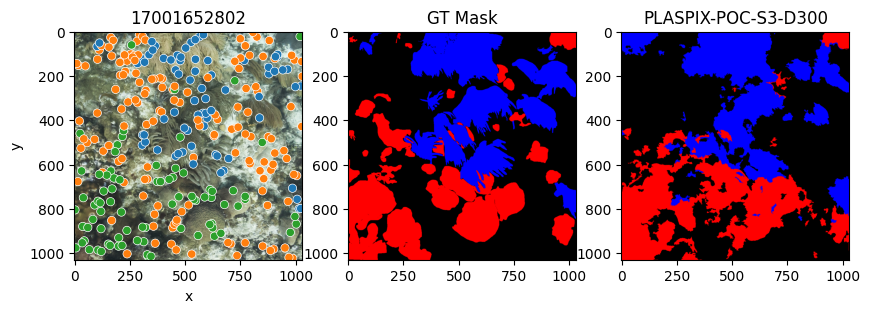

In [ ]:
index = 0
visualize_output(**label_prop_data[index])